In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 스마트팜 배출량에 대한 예측
- smart_farm_final.csv

# Pycaret을 이용한 튜닝 및 예측
 - 3 표준편차 기준 이상치 대체 반응변수
 - 왜도 3 이상 값들 로그변환 설명변수
 - VIF < 11 인 값들
 - 부스팅 / 배깅 / 블랜딩 3개 혼합모델

In [16]:
#data = pd.read_csv("smart_farm_final.csv").sample(n = 50000)
org_data = pd.read_csv("smart_farm_final.csv")
org_data.shape

(148168, 57)

시간 데이터 처리하기
- 연도 : numerical
- 월 : non numerical
- 일 : non numerical
- 시 : non numerical
- 분 : non numerical

In [17]:
data = org_data.drop(["시간","년월일","년도","월","일","시","분"],axis=1)
#data = org_data.drop(["시간","년월일","분"],axis=1)

#### 팬코일 B동 데이터
- 0과 1이 아닌, 0.5 발견
- 반올림 처리하기

In [5]:
data["팬코일 B동"].value_counts()

1.0    93920
0.0    54246
0.5        2
Name: 팬코일 B동, dtype: int64

In [6]:
data["팬코일 B동"] = data["팬코일 B동"].apply(lambda x : 1 if x == 0.5 else x )

In [7]:
data["팬코일 B동"].value_counts()

1.0    93922
0.0    54246
Name: 팬코일 B동, dtype: int64

In [8]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

문자열 칼럼 추출

In [149]:
# 문자열 형식의 컬럼만 추출하기
object_lst = []

# 숫자 형식의 컬럼만 추출하기
num_lst = []

for col in data.columns:
    if data[col].dtype == "object":
        object_lst.append(col)
    
    else:
        num_lst.append(col)

In [150]:
# 카테고리열 제거한 numerical
# 진짜 숫자 관련 열만 존재

num_lst_real = [x for x in num_lst if x not in ["월","일","시",'배기팬','유동팬','팬코일 B동',"차광스크린_개방",
                                                "열공급량(kWh)","환기온도(천창 제어온도)"]]

object_lst_real = object_lst + ['배기팬','유동팬','팬코일 B동', "차광스크린_개방","환기온도(천창 제어온도)"]

object_no_binary = [x for x in object_lst_real if x not in ["배기팬","유동팬","팬코일 B동","차광스크린_개방","환기온도(천창 제어온도)"]]

#### MeanEncoding을 하기 위한 EDA 작업하기
- object_lst_real : categorial data
- num_lst_real : numeric data

In [151]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [152]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [139]:
print(len(num_lst_real))
print(len(object_lst_real))

31
18


#### Num 데이터

In [10]:
data["천창"].skew()

4.579098139125924

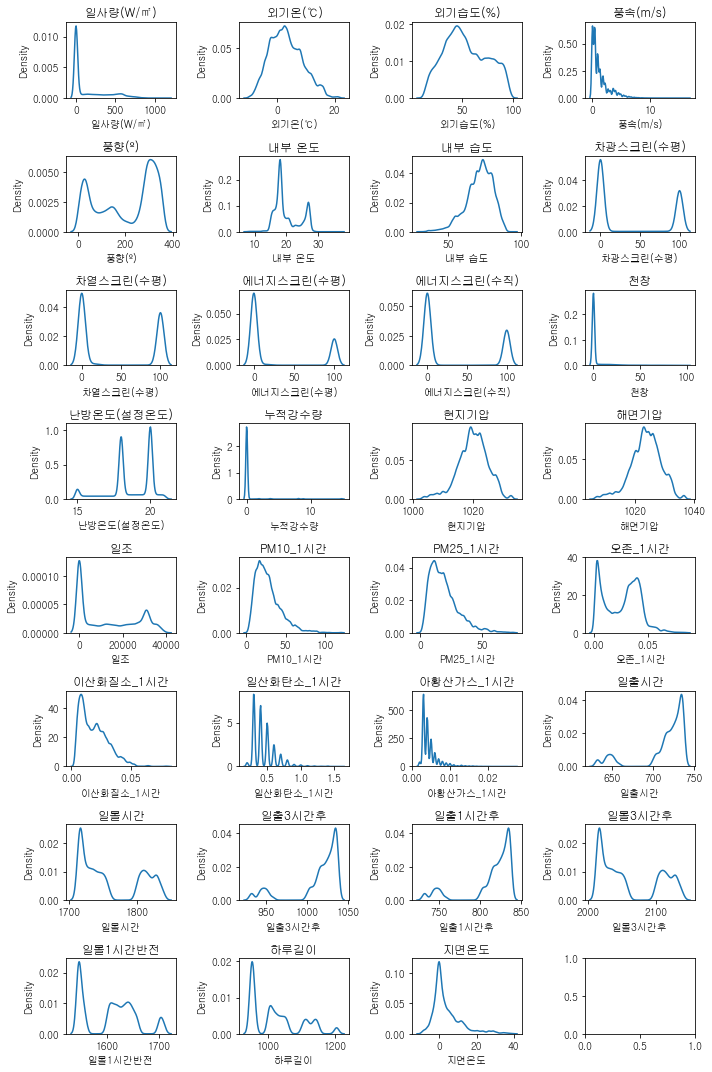

In [54]:
fig,ax = plt.subplots(8,4, figsize=(10,15))

for i in range(len(num_lst_real)):
    x_num = i//4
    y_num = i%4
    
    try:
        ax[x_num, y_num] = sns.kdeplot(data.loc[:,num_lst_real[i]], ax = ax[x_num][y_num])
        ax[x_num, y_num].set_title(num_lst_real[i])
    except:
        pass
    
plt.tight_layout()
plt.show()

- catergoric 같은 데이터 : 스크린 계열 -> 0~100 올라가는 데이터
- skew가 커보이는 데이터 : 강수, 천창, 아황산, 풍속, 일사

#### Num 데이터 로그변환

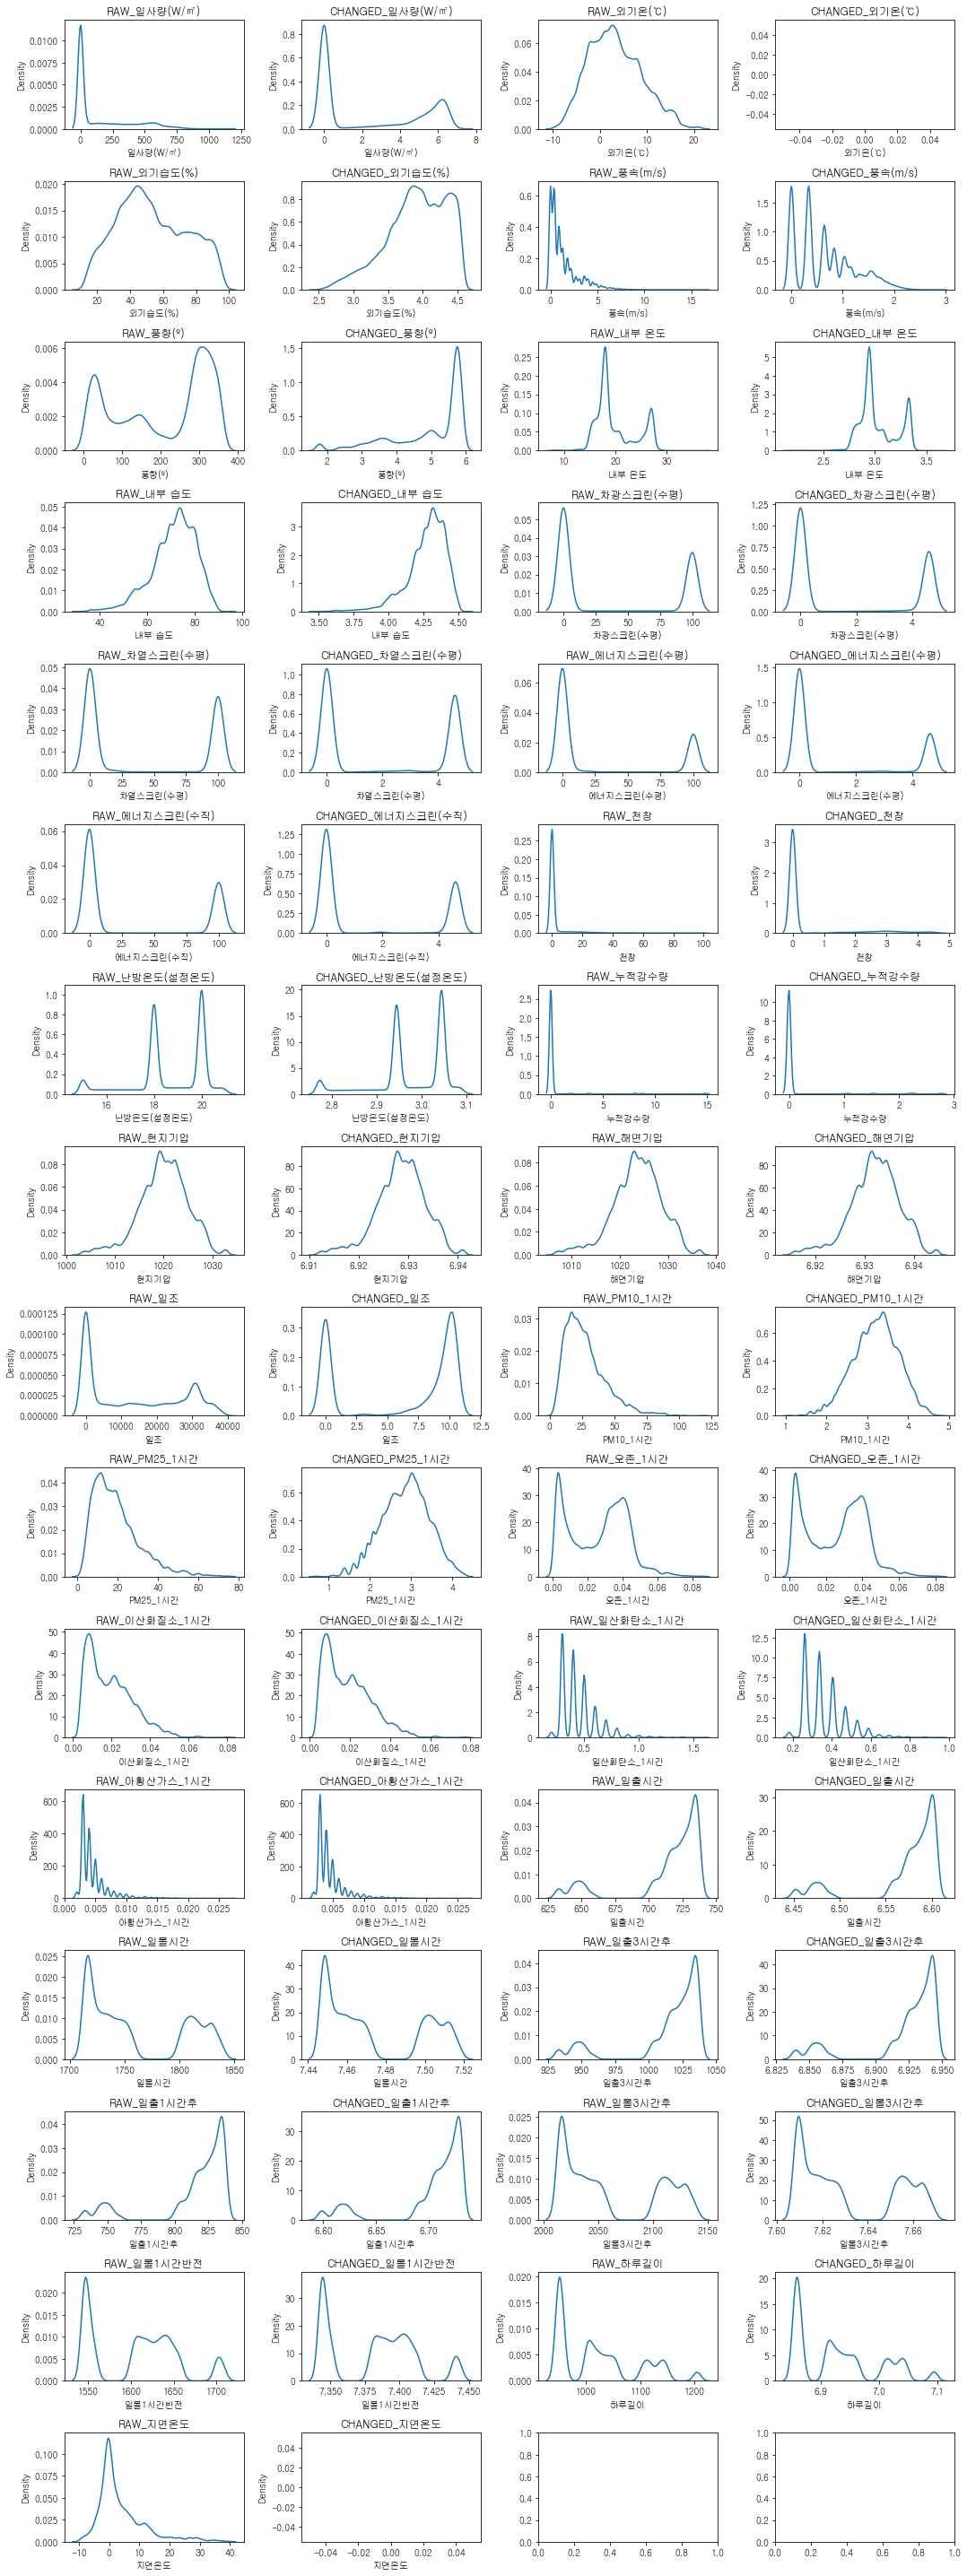

In [43]:
fig,ax = plt.subplots(16,4, figsize=(15,40))
df = data.copy()[num_lst_real]

changed_df = np.log1p(df)
columns = num_lst_real

for i in range(64):
    try:
        column = columns[i//2]
        x_num = i // 4
        y_num = i % 4
        
    except:
        pass
    
    try:
        if i % 2 == 0:
            ax[x_num,y_num] = sns.kdeplot(df.iloc[:,i//2], ax = ax[x_num][y_num])
            ax[x_num,y_num].set_title('RAW_'+column)
        else:
            ax[x_num,y_num] = sns.kdeplot(changed_df.iloc[:,i//2], ax = ax[x_num][y_num])
            ax[x_num,y_num].set_title('CHANGED_'+column)
    except:
        pass
    
plt.tight_layout()
plt.show()

#df.loc[:,columns] = changed_train_QE

log 변환이 필요한가?

#### Object 데이터
- 차광스크린 광도조절
- 차열스크린 광도조절
- 데이터 제거하기

In [48]:
len(object_lst_real)

18

In [49]:
data["차열스크린_광도조절"].value_counts()

800미만    148168
Name: 차열스크린_광도조절, dtype: int64

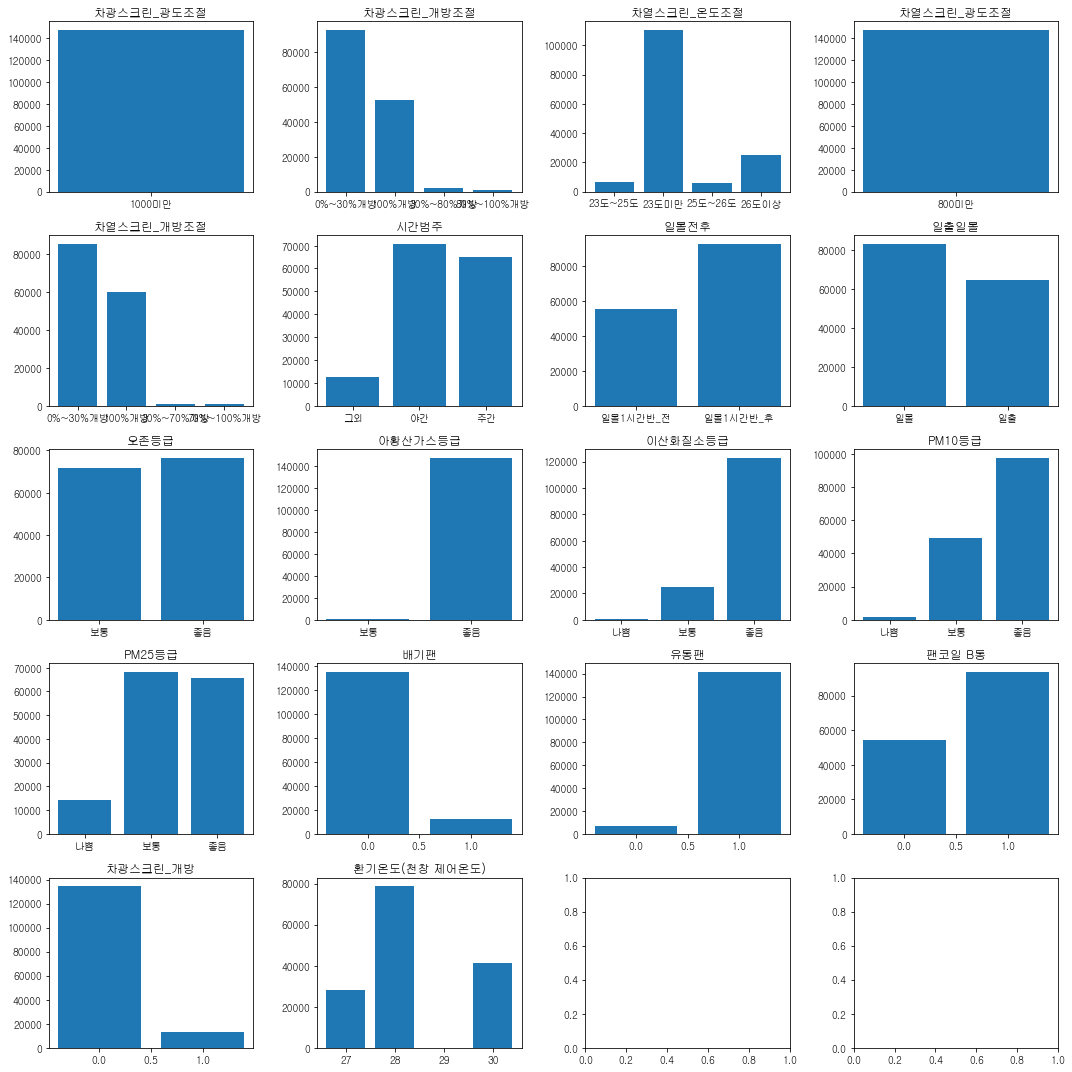

In [50]:
fig,ax = plt.subplots(5,4, figsize=(15,15))

for i in range(20):
    x_num = i//4
    y_num = i%4

    try:
        plot_dict = data.loc[:,object_lst_real[i]].value_counts().to_dict()
        x_values = sorted(plot_dict.keys())
        y_values = [plot_dict[x] for x in x_values]

        ax[x_num, y_num].bar(x_values, y_values)
        ax[x_num, y_num].set_title((object_lst_real[i]))

    except:
        pass
    
plt.tight_layout()
plt.show()

data_encode : MeanEncoding을 위한 데이터

In [69]:
data_encode = data.copy()

In [153]:
for col in object_lst_real:
    mean_df = data.groupby(col)['열공급량(kWh)'].agg('mean')
    display(mean_df)

    data[col] = data[col].map(mean_df)

차광스크린_광도조절
1000미만    0.357508
Name: 열공급량(kWh), dtype: float64

차광스크린_개방조절
0%~30%개방      0.448048
100%개방        0.189656
30%~80%개방     0.451388
80%~100%개방    0.450717
Name: 열공급량(kWh), dtype: float64

차열스크린_온도조절
23도~25도    0.184928
23도미만      0.430601
25도~26도    0.146263
26도이상      0.122793
Name: 열공급량(kWh), dtype: float64

차열스크린_광도조절
800미만    0.357508
Name: 열공급량(kWh), dtype: float64

차열스크린_개방조절
0%~30%개방      0.453742
100%개방        0.218752
30%~70%개방     0.377856
70%~100%개방    0.382461
Name: 열공급량(kWh), dtype: float64

시간범주
그외    0.259557
야간    0.470258
주간    0.249193
Name: 열공급량(kWh), dtype: float64

일몰전후
일몰1시간반_전    0.216276
일몰1시간반_후    0.439170
Name: 열공급량(kWh), dtype: float64

일출일몰
일몰    0.448184
일출    0.237041
Name: 열공급량(kWh), dtype: float64

오존등급
보통    0.324475
좋음    0.384892
Name: 열공급량(kWh), dtype: float64

아황산가스등급
보통    0.09500
좋음    0.35824
Name: 열공급량(kWh), dtype: float64

이산화질소등급
나쁨    0.439286
보통    0.391550
좋음    0.349792
Name: 열공급량(kWh), dtype: float64

PM10등급
나쁨    0.255542
보통    0.342497
좋음    0.365512
Name: 열공급량(kWh), dtype: float64

PM25등급
나쁨    0.350130
보통    0.354853
좋음    0.361944
Name: 열공급량(kWh), dtype: float64

배기팬
0    0.377021
1    0.122027
Name: 열공급량(kWh), dtype: float64

유동팬
0    0.134801
1    0.366450
Name: 열공급량(kWh), dtype: float64

팬코일 B동
0.0    0.195136
1.0    0.443911
Name: 열공급량(kWh), dtype: float64

차광스크린_개방
0    0.379087
1    0.118246
Name: 열공급량(kWh), dtype: float64

환기온도(천창 제어온도)
27    0.350582
28    0.448811
30    0.180268
Name: 열공급량(kWh), dtype: float64

(148168, 50)

##### binary categorial 은 원핫인코딩(get_dummies)하지 않기
- 희소행렬이 만들어지는 것을 방지하기 위함
- 환기온도도 categorical처럼 보이지만 크기 자체에 의미가 있어서 numerical로

## 변수 선택 이전 스케일링, 로그변환, 이상치 처리

#### 이상치 대체하기
- 스크린 계열 데이터 0 ~ 100이니까 처리하지 않기

In [103]:
def replace_outlier_zscore(df,columns,n):
    data = df.copy()
    mean = np.mean(data[columns])
    std = np.std(data[columns])
    score_top = int(n)*std + mean
    score_bot = -1*n*std + mean
    
    def cond1(x):
        if x > score_top:
            return score_top
        if x < score_bot:
            return score_bot
        else:
            return x
    data[columns] = data[columns].apply(cond1)
    
    return data[columns]

In [18]:
loglist=[]
# 왜도 3인 설명변수 log1p 변환
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    if abs(data[val].skew()) > 2:
        print("log1p 변환이전 : ",abs(data[val].skew()))
        print(val)

loglist

log1p 변환이전 :  4.579098139125924
천창
log1p 변환이전 :  7.384725752483332
누적강수량
log1p 변환이전 :  3.13108520363669
아황산가스_1시간


[]

이상치 대체하는 함수

In [142]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = data[col]

In [105]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = replace_outlier_zscore(data,col+"_scale",3)

In [106]:
len(['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도'])

18

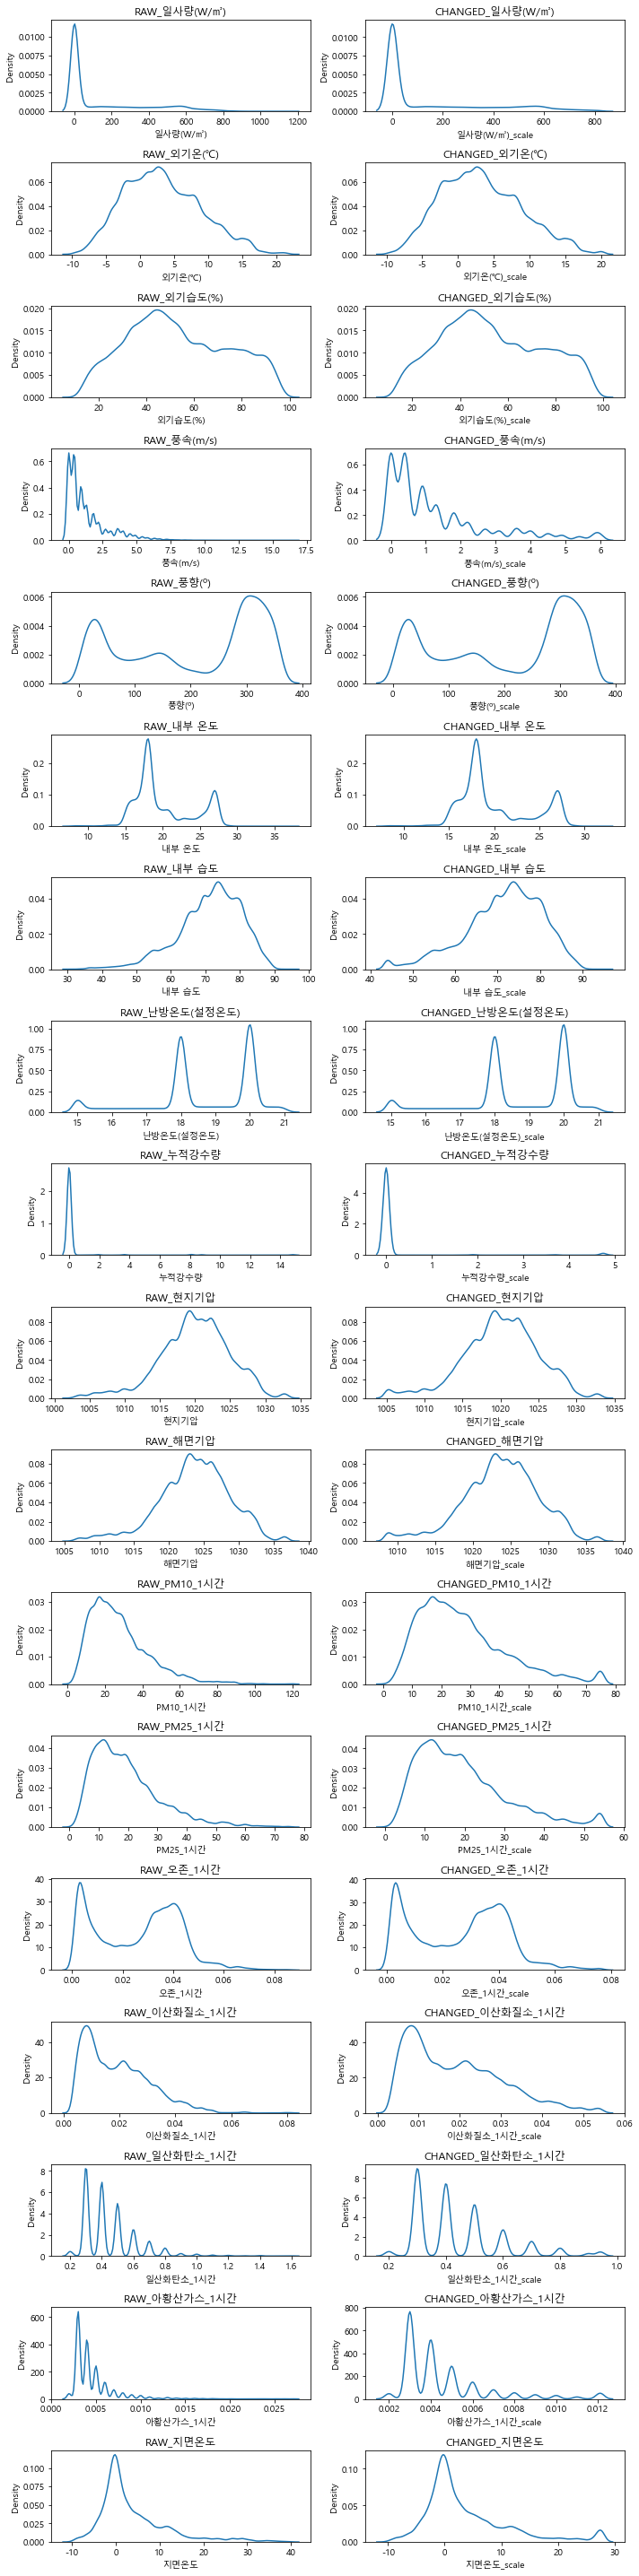

In [107]:
outlier_columns = ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']

fig,ax = plt.subplots(18,2, figsize=(10,40))

for i in range(36):
    x_num = i//2
    y_num = i%2
    column = outlier_columns[i//2]
    if i %2 == 0:
        ax[x_num,y_num] = sns.kdeplot(data.loc[:,column], ax = ax[x_num][y_num])
        ax[x_num,y_num].set_title('RAW_'+column)
    else:
        
        ax[x_num,y_num] = sns.kdeplot(data.loc[:,column+"_scale"], ax = ax[x_num][y_num])
        ax[x_num,y_num].set_title('CHANGED_'+column)
plt.tight_layout()
plt.show()

이상치 개수 확인

In [108]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    if (data[col] == data[col+"_scale"]).sum() == 148168:
        pass
    else:
        print(col)
        print("이상치 비율 : ",(148168 - (data[col] == data[col+"_scale"]).sum()) / 148168 * 100)
        print(" ---------------------------------------------- ")
        
    data.drop([col+"_scale"],axis=1,inplace=True)

일사량(W/㎡)
이상치 비율 :  0.35500242967442364
 ---------------------------------------------- 
외기온(℃)
이상치 비율 :  0.22541979374763782
 ---------------------------------------------- 
풍속(m/s)
이상치 비율 :  1.6596026132498245
 ---------------------------------------------- 
내부 온도
이상치 비율 :  0.06816586577398628
 ---------------------------------------------- 
내부 습도
이상치 비율 :  0.8773824307542789
 ---------------------------------------------- 
누적강수량
이상치 비율 :  1.9565628205820422
 ---------------------------------------------- 
현지기압
이상치 비율 :  0.6195669780249446
 ---------------------------------------------- 
해면기압
이상치 비율 :  0.6087684250310459
 ---------------------------------------------- 
PM10_1시간
이상치 비율 :  1.5705145510501592
 ---------------------------------------------- 
PM25_1시간
이상치 비율 :  1.4071864370174396
 ---------------------------------------------- 
오존_1시간
이상치 비율 :  0.20247286863560285
 ---------------------------------------------- 
이산화질소_1시간
이상치 비율 :  0.3624264348577291
 ---------------------

#### 1. 숫자형 데이터 스케일링 진행
- 컬럼별로 스케일링 진행
- 스크린 계열 데이터 스케일링 진행하기

In [110]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [111]:
data.head()

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차광스크린_광도조절,차광스크린_개방조절,차열스크린_온도조절,차열스크린_광도조절,차열스크린_개방조절,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급
0,0.0,5.8,67,0.0,325,18.3,62.0,0,0,0,0,0.377021,0,0.36645,0.195136,0.448811,18.0,0.9,0.0,1018.2,1021.9,29180.0,33.0,22.0,0.003,0.028,0.4,0.003,0.379087,0.357508,0.448048,0.430601,0.357508,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,2.7,0.384892,0.35824,0.349792,0.342497,0.354853
1,0.0,5.8,67,0.4,344,18.1,63.4,0,0,0,0,0.377021,0,0.36645,0.195136,0.448811,18.0,0.9,0.0,1018.2,1021.9,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0.379087,0.357508,0.448048,0.430601,0.357508,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,2.7,0.384892,0.35824,0.349792,0.342497,0.354853
2,0.0,5.7,67,0.9,105,17.7,65.2,0,0,0,0,0.377021,0,0.36645,0.443911,0.448811,18.0,0.9,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0.379087,0.357508,0.448048,0.430601,0.357508,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,2.7,0.384892,0.35824,0.349792,0.342497,0.354853
3,0.0,5.7,67,1.3,123,17.7,63.9,0,0,0,0,0.377021,0,0.36645,0.443911,0.448811,18.0,0.8,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0.379087,0.357508,0.448048,0.430601,0.357508,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,2.7,0.384892,0.35824,0.349792,0.342497,0.354853
4,0.0,5.7,67,0.9,123,17.6,64.7,0,0,0,0,0.377021,0,0.36645,0.443911,0.448811,18.0,1.0,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0.379087,0.357508,0.448048,0.430601,0.357508,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,2.7,0.384892,0.35824,0.349792,0.342497,0.354853


In [ ]:
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도',"환기온도(천창 제어온도)"]:
    
    scaler = StandardScaler()
    
    
    data_scaled = scaler.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

In [154]:
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    minmax = MinMaxScaler()
    
    data_scaled = minmax.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

#### 광도조절 데이터 제거하기
- 데이터가 다 똑같음

In [155]:
data.drop(["차열스크린_광도조절","차광스크린_광도조절"],axis=1,inplace=True)

"배기팬","유동팬","팬코일 B동","환기온도(천창 제어온도)" 카테고리열 데이터로 스케일링 필요없음
- 환기온도는 numerical로 보면 필요한 것 같기도...

#### 1.1 데이터 처리하기
- 학습용 데이터 : ~2022.03
- 예측용 데이터 : 2022.03~

X 데이터 처리하기
- dummy 처리
- 왜도 처리

In [156]:
data_scaled = data.copy()
data_scaled.head(3)

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차광스크린_개방조절,차열스크린_온도조절,차열스크린_개방조절,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급
0,0.0,0.495238,0.643678,0.000000,0.901408,0.359322,0.485804,0.0,0.0,0.0,0.0,0.377021,0.0,0.36645,0.195136,0.448811,0.5,0.9,0.0,0.506494,0.506452,29180.0,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0.379087,0.448048,0.430601,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,0.254545,0.384892,0.35824,0.349792,0.342497,0.354853
1,0.0,0.495238,0.643678,0.024242,0.954930,0.352542,0.507886,0.0,0.0,0.0,0.0,0.377021,0.0,0.36645,0.195136,0.448811,0.5,0.9,0.0,0.506494,0.506452,0.0,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0.379087,0.448048,0.430601,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,0.254545,0.384892,0.35824,0.349792,0.342497,0.354853
2,0.0,0.492063,0.643678,0.054545,0.281690,0.338983,0.536278,0.0,0.0,0.0,0.0,0.377021,0.0,0.36645,0.443911,0.448811,0.5,0.9,0.0,0.503247,0.503226,0.0,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0.379087,0.448048,0.430601,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,0.254545,0.384892,0.35824,0.349792,0.342497,0.354853


In [157]:
data_scaled.shape

(148168, 48)

In [158]:
# 년도 데이터를 numerical로 처리하기
Y = data_scaled["열공급량(kWh)"]

X_dummy = data_scaled.drop("열공급량(kWh)",axis=1)

년월일 데이터 붙이기

In [159]:
data_scaled_final = pd.concat([X_dummy, Y], axis = 1)

In [160]:
data_scaled_final["년도"] = org_data["년도"].values
data_scaled_final["월"] = org_data["월"].values
data_scaled_final["일"] = org_data["일"].values
data_scaled_final["시"] = org_data["시"].values

In [161]:
train_data = data_scaled_final.iloc[:129448,:]

test_data = data_scaled_final.iloc[129448:,:]

### 선택된 변수 기반의 예측

- selected_variables : backward로 변수선택
- selected_variables : stepwise로 변수선택
- 2가지 경우 존재

#### 변수 선택 다시 돌리기

In [162]:
train_data.head(2)

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차광스크린_개방조절,차열스크린_온도조절,차열스크린_개방조절,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급,열공급량(kWh),년도,월,일,시
0,0.0,0.495238,0.643678,0.000000,0.901408,0.359322,0.485804,0.0,0.0,0.0,0.0,0.377021,0.0,0.36645,0.195136,0.448811,0.5,0.0,0.506494,0.506452,29180.0,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0.379087,0.448048,0.430601,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,0.254545,0.384892,0.35824,0.349792,0.342497,0.354853,0.9,2021,11,26,0
1,0.0,0.495238,0.643678,0.024242,0.954930,0.352542,0.507886,0.0,0.0,0.0,0.0,0.377021,0.0,0.36645,0.195136,0.448811,0.5,0.0,0.506494,0.506452,0.0,0.264957,0.283784,0.02381,0.320513,0.142857,0.04,0.379087,0.448048,0.430601,0.453742,713,1717,1013,813,2017,1547,1004,0.470258,0.43917,0.448184,0.254545,0.384892,0.35824,0.349792,0.342497,0.354853,0.9,2021,11,26,0


In [178]:
## 후진 소거법
df = train_data.drop(["년도","월","일","시"],axis=1).copy()

variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = df['열공급량(kWh)'] ## 반응 변수

In [179]:
selected_variables = variables.copy() ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.15
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(df[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
        
        print("수정된 결졍계수 ",adj_r_squared)
        
        print("제거된 변수 ",remove_variable)
    else:
        break

수정된 결졍계수  0.2914323812638556
제거된 변수  난방온도(설정온도)
수정된 결졍계수  0.2914323812638556
제거된 변수  일출3시간후
수정된 결졍계수  0.2914323812638556
제거된 변수  일몰시간
수정된 결졍계수  0.2914323812638556
제거된 변수  일출1시간후
수정된 결졍계수  0.29143558118835855
제거된 변수  일몰3시간후
수정된 결졍계수  0.29143862999509296
제거된 변수  PM10_1시간
수정된 결졍계수  0.2914393147035219
제거된 변수  아황산가스등급
수정된 결졍계수  0.2914398826833694
제거된 변수  일출일몰
수정된 결졍계수  0.29143722303072106
제거된 변수  해면기압


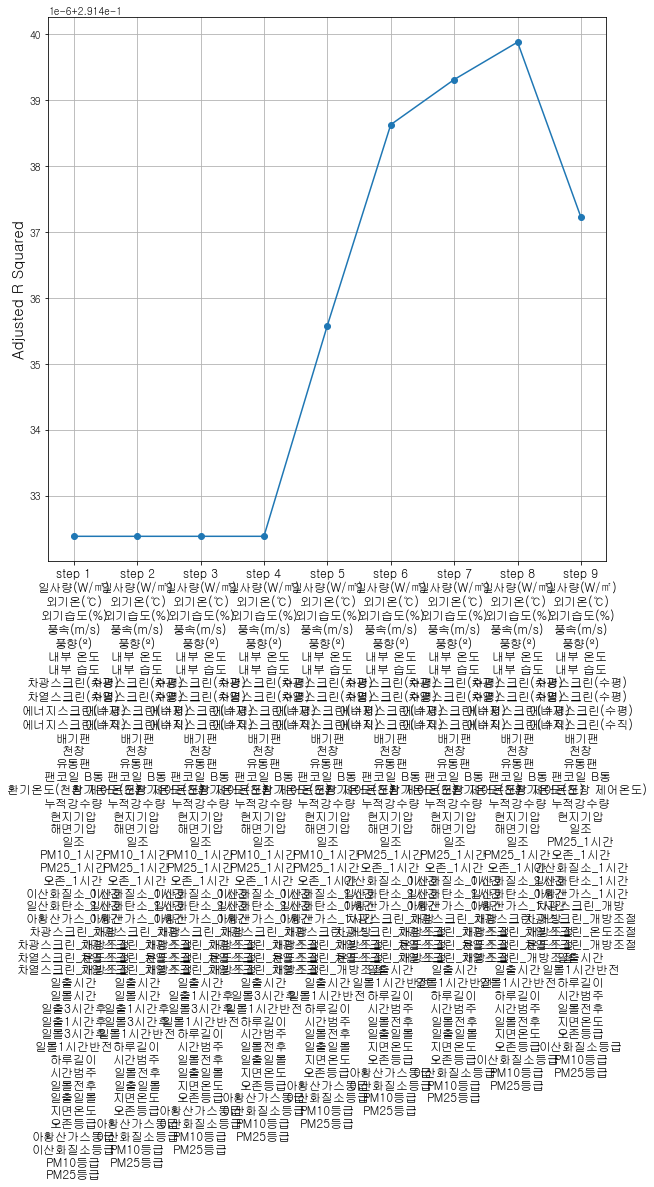

In [180]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

변수 선택 제대로 안된다 다시 확인... 꼭

In [ ]:
np.save("backward_meanencoding.npy",selected_variables)

변수 다시 한번 재가공

In [ ]:
selected_variables = [x for x in selected_variables if x not in ['팬코일 B동_0.5', '년도_2021', '년도_2022',
                                                                '배기팬_0', '배기팬_1','유동팬_0', '유동팬_1','팬코일 B동_0.0',
                                                                 '팬코일 B동_1.0','환기온도(천창 제어온도)_27',
                                                                 '환기온도(천창 제어온도)_28','환기온도(천창 제어온도)_30',
                                                                 '차광스크린_개방_0', '차광스크린_개방_1','팬코일 B동_1.0']]

selected_variables += ["년도","월","일","시","팬코일 B동","배기팬","유동팬","차광스크린_개방","환기온도(천창 제어온도)"]

In [ ]:
x_train = train_data.drop(["열공급량(kWh)"],axis=1)[selected_variables]
y_train = train_data["열공급량(kWh)"]

x_test = test_data.drop(["열공급량(kWh)"],axis=1)[selected_variables]
y_test = test_data["열공급량(kWh)"]

In [ ]:
x_train.head(3)

In [ ]:
년월일 데이터 붙이기

In [ ]:
data_transform = pd.concat([x_train,np.log1p(y_train)],axis=1)
data_transform.shape

In [ ]:
data_transform

In [ ]:
reg_lunch = setup(
        data = data_transform,
        target='열공급량(kWh)',
        train_size=0.8,
        session_id = 0,
        data_split_shuffle=False,
        normalize = False,
        fold_strategy = 'timeseries',
        numeric_features = ["년도","월"],
        categorical_features = ["일","시","팬코일 B동","배기팬","유동팬","차광스크린_개방"],
        fold = 5,
        verbose=True,
        transform_target = False,
        silent= False, n_jobs= 1)

In [ ]:
best_5_d = compare_models(sort = 'RMSE', n_select = 5,round=4,cross_validation=True,verbose=True)
print(best_5_d)

In [ ]:
### 모델 생성 및 튜닝
- ada boost
- orthogonal mathcing pursuit

In [ ]:
gbr_model = create_model("gbr")

In [ ]:
tuned_models = []

best_model = tune_model(gbr_model, fold= 3, n_iter = 100, optimize = 'RMSE', verbose = True, choose_better = True)
tuned_models.append(best_model)

In [ ]:
best_model

모델 저장하기
- adaboost_ver1
- 타겟 데이터 log 변환 O
- 이상치 대체하기 X
- 왜도가 높은 것들 log 변환 X
- Normalization

In [ ]:
import joblib
joblib.dump(ada_model, 'adaboost_ver1.pkl')
# model = joblib.load('adaboost_ver1.pkl') : 모델 읽어오기

모델 불러오기

In [ ]:
import joblib
ada_model = joblib.load('adaboost_ver1.pkl')

모델로 예측하기

In [ ]:
final_model = best_model

In [ ]:
prediction = predict_model(final_model, data = x_test)

In [ ]:
lr = create_model('lr')
plot_model(final_model, plot = 'feature')

# this is how you can recreate the table
import pandas as pd
pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(lr.coef_[0])}).sort_values(by='Value', ascending=False)

#### 로그역변환 반드시 하기

In [ ]:
prediction["Label"]

In [ ]:
predict_df = org_data.iloc[129448:,:].copy()
predict_df["열공급량(kWh)"] = prediction["Label"].apply(lambda x : np.exp(x)-1)

In [ ]:
predict_df["년월일"].value_counts()

In [ ]:
predict_df[["년월일","열공급량(kWh)"]].head()

In [ ]:
predict_df.rename(columns={'년도':'yy'},inplace=True)
predict_df.rename(columns={'월':'mm'},inplace=True)
predict_df.rename(columns={'일':'dd'},inplace=True)

제출용 데이터로 가공하기

In [ ]:
submit_df = pd.read_csv("2-1_검증데이터셋.csv")

In [ ]:
submit_df = pd.merge(submit_df[["yy","mm","dd"]],predict_df[["yy","mm","dd","시","분","열공급량(kWh)"]],
                     on = ["yy","mm","dd"], how = "inner").reset_index()

submit_df = submit_df.groupby(["yy","mm","dd"]).sum().reset_index()

In [ ]:
submit_df.drop(["index","시","분"],axis=1,inplace=True)

In [ ]:
submit_df.rename(columns={'열공급량(kWh)':'heat_supply_day'},inplace=True)

In [ ]:
submit_df.to_csv("220104_gbr_model_ver1.csv",encoding="utf-8-sig",index=False)

In [ ]:
submit_df["heat_supply_day"].sum()

In [ ]:
plot 그려보기

In [ ]:
predict_df[["년월일","시","분","열공급량(kWh)"]]

In [ ]:
compare_df = pd.concat([org_data[["년월일","시","분","열공급량(kWh)"]].iloc[:129448,:],
                       predict_df[["년월일","시","분","열공급량(kWh)"]]],
                      ignore_index = True)

In [ ]:
compare = compare_df.groupby(["년월일"]).sum().reset_index()

In [ ]:
#compare[["년월일","열공급량(kWh)"]].to_csv("test.csv",encoding="utf-8-sig",index=False)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,6))
compare[["년월일","열공급량(kWh)"]].set_index("년월일").plot(ax=ax)